# Imports

In [8]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import  QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit_textbook.tools import array_to_latex

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

/home/ludvins/.local/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2020-11-05 11:00:23,073: Credentials are already in use. The existing account in the session will be replaced.


# Planteamiento del problema

Sea $n \in \mathbb{N}$ fijo y conocido, $s \in \{0,1\}^n$ desconocido y la aplicacación 
$$
\begin{aligned}
f:\{0,1\}^n &\to \{0,1\}\\
x &\mapsto (x·s) \text{ mod}(2)
\end{aligned}
$$
Donde $(x·s)$ es la multiplicación bit a bit de ambos elementos. Se plantea descubir el valor de $s$.

# Resolución

## Clásica

El algoritmo clásico para resolver el problema se basa en la siguiente idea: dado un elemento $x \in \{0,1\}^n$ tal que $x$ está formado por todo $0$'s excepto un $1$ en la posición $j$-ésima. 
$$
f(x) = s_j%2 = s_j.
$$
Entonces, si aplicamos la función a cada elemento del conjunto $\{(10\dots 0),(010\dots 0)\dots (0\dots 0 1)\}$ obtenemos los $n$ valores que componen a $s$ con un total de $n$ iteraciones.


## Cuántica

Explicamos ahora el funcionamiento del algoritmo de Bernstein-Vazirani para resolver el problema utilizando computación cuántica.

Utilizaremos la siguiente propiedad del la puerta de Hadamard:

**Proposición**. Sea $\lvert a \rangle$ un qbit de dimensión $n$ y $H^{\otimes n}$ la puerta de Hadamard de dimensión $n$. Se verifica:
$$
H^{\otimes n} \lvert a \rangle = \frac{1}{\sqrt{2^n}} \sum_{x\in\{0,1\}^n} (-1)^{a·x} \lvert x \rangle
$$

**Demostración.** Comprobar lo que se pide es equivalente a demostrar que la forma matricial de $H^{\otimes n}$ es
$$
H^{\otimes n} = \frac{1}{2^{n/2}}\begin{pmatrix}  (-1)^{i·j}\end{pmatrix}_{i,j}
$$

Procedemos mediante un razonamiento inductivo. Sea $n = 1$.
$$
H^1 = \frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix}
$$
La cual cumple la proposición. Supongamos ahora que $H^{\otimes n-1}$ lo verifica, veamos que lo hace $H^{\otimes n}$:
$$
H^{\otimes n} = H^1 \otimes H^{\otimes n-1} = \frac{1}{\sqrt{2}} \begin{pmatrix} H^{\otimes n-1} & H^{\otimes n-1} \\ H^{\otimes n-1} & -H^{\otimes n-1}\end{pmatrix}
$$
El hecho de que el primer cuadrante (superior izquierdo) cumpla lo que buscamos es evidente, pues los indices $i,j$ son los mismos que hacen que $H^{\otimes n-1}$ lo verifique. Por otro lado, para el resto de cuadrantes utilizamos la siguiente idea: los indices correspondientes al cuadrante superior derecho coindicen con añadir un 1 en binario a la izquierda del indice de las columnas y un 0 en el de las filas (viceversa en el cuadrante inferior izquierdo), es decir, sea $i$ y $j$ dos índices del primer cuadrante, los del segundo se pueden construir como $0i$ y $1j$ en binario. Por lo tanto, al realizar la multiplicación a nivel de bits, el resultado no se altera
$$
\begin{pmatrix}  (-1)^{i·j}\end{pmatrix}_{i,j} = \begin{pmatrix}  (-1)^{i·(n+j)}\end{pmatrix}_{i,j} = \begin{pmatrix}  (-1)^{(i+n)·j}\end{pmatrix}_{i,j}.
$$
Siguiendo la misma idea los indices correspondientes a el cuadrante inferior derecho son iguales a los originales añadiendo un 1 a ambos indices.
$$
\begin{pmatrix}  (-1)^{(i+n)·(j+n)}\end{pmatrix}_{i,j} = -1 \begin{pmatrix}  (-1)^{i·j}\end{pmatrix}_{i,j}.
$$

Notamos ahora que 
$$
H^{\otimes n} \lvert 00\dots 0 \rangle = \frac{1}{\sqrt{2^n}} \sum_{x\in\{0,1\}^n} \lvert x \rangle
$$

Definimos entonces una puerta cuántica a partir de la función que buscamos 
$$
F\lvert x \rangle = (-1)^{f(x)}\lvert x \rangle = (-1)^{s·x} \lvert x \rangle.
$$
Utilizando que la puerta de Hadamard es su propia inversa, tenemos:
$$
 \lvert 00\dots 0 \rangle \xrightarrow{H^{\otimes n}} \frac{1}{\sqrt{2^n}} \sum_{x\in\{0,1\}^n} \lvert x \rangle \xrightarrow{F}  \frac{1}{\sqrt{2^n}} \sum_{x\in\{0,1\}^n} (-1)^{s·x} \lvert x \rangle \xrightarrow{H^{\otimes n}} \lvert s \rangle
$$

## Circuito Cuántico

In [41]:
n = 5
s = '01100'

In [45]:
# Necesitamos 1 registro mas del tamaño de s
q = QuantumRegister(n+1, 'q')
# Tantos registros de escritura como bits tenga s
c = ClassicalRegister(n, 'c')
circuit = QuantumCircuit(q, c)

# Aplicamos H a todos los qbits
circuit.h(q)
circuit.z(q[n])
    
# Apply barrier 
circuit.barrier()

s = s[::-1]
for i in range(n):
    if s[i] != '0':
        circuit.cnot(q[i], q[n])

# Apply barrier 
circuit.barrier()

circuit.h(q[0:n])


circuit.measure(q[0:n], c[0:n])

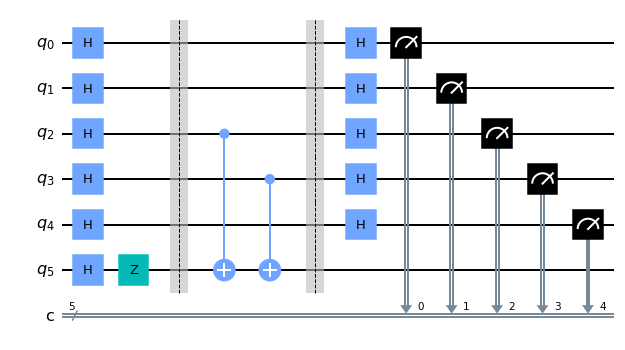

In [46]:
circuit.draw(output='mpl')

In [47]:
# Set backend proider
backend = provider.get_backend('ibmq_qasm_simulator')

# Execute the circuit 1024 times
job = execute(circuit, backend, shots=1024)

print('Executing Job...\n')
result = job.result()
counts = result.get_counts(circuit)

print("Results: ", counts)

Executing Job...

Results:  {'01100': 1024}
